In [2]:
from spyglass.common import Session
from spyglass_hexmaze.hex_maze_behavior import HexMazeBlock, HexMazeChoice
import pandas as pd

# Join HexMazeChoice with a bunch of other tables
# We need the Session table for session_id and subject_id
# We need HexMazeBlock and Trial for opto_cond and session_type
df = pd.DataFrame(
    (HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True)
)

# Binary dependent variable
df["choose_left"] = (df["choice_direction"] == "left").astype(int)

# Open question: in Tim's paper, random effects were estimated over the levels of rat and session-within-rat.
# For Berke Lab, we only have one session (epoch) per day. BUT for Frank lab, we have multiple epochs per session.
# Do we want to estimate random effects over the level of epoch_id instead of (or in addition to??), session_id?
df["epoch_id"] = df["session_id"].astype(str) + "_epoch" + df["epoch"].astype(str)

# Keep only columns useful for regression
regression_cols = [
    "subject_id",  # random effect
    "session_id",  # nested grouping/random effect
    "epoch_id",  # nested grouping/random effect
    "session_description",  # we may want to filter based on opto sessions (Frank Lab)
    "opto_cond",  # we may want to filter based on opto condition to see effects here
    "task_type",  # we may want to filter based on `probability change` vs `barrier change`
    "block",  # we may want to filter based on block?
    "block_trial_num",  # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "choose_left",  # binary dependent variable
    "reward_prob_diff",  # predictor
    "path_length_diff",  # predictor
]
regression_df = df[regression_cols].copy()

# Convert all non-numeric columns to 'category' dtype
for col in regression_df.columns:
    if not pd.api.types.is_numeric_dtype(regression_df[col]):
        regression_df[col] = regression_df[col].astype("str")

display(regression_df)

,subject_id,session_id,epoch_id,session_description,opto_cond,task_type,block,block_trial_num,choose_left,reward_prob_diff,path_length_diff
0,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,no_delay,probability change,1,2,1,40.0,2
1,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,None,probability change,1,3,1,-80.0,-6
2,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,no_delay,probability change,1,4,0,-40.0,-4
3,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,delay,probability change,1,5,0,80.0,6
4,BraveLu,BraveLu_20240516,BraveLu_20240516_epoch1,RippleStimDelayNoDelay,delay,probability change,1,6,1,40.0,2
...,...,...,...,...,...,...,...,...,...,...,...
7569,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,14,0,40.0,2
7570,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,15,1,80.0,0
7571,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,16,0,40.0,2
7572,Toby,Toby_20250318,Toby_20250318_epoch7,HexmazeNoStim,None,barrier change,5,17,1,80.0,0


In [2]:
from spyglass.common import Session

subset = regression_df[
    (regression_df["subject_id"] == "BraveLu")
    & (regression_df["session_description"] == "ThetaStimLatePhase")
]
subset

subset["session_id"].unique()

array(['BraveLu_20240617', 'BraveLu_20240622'], dtype=object)

In [3]:
df = pd.DataFrame(
    (HexMazeChoice() * HexMazeBlock().join_with_trial() * Session()).fetch(as_dict=True)
)
# Keep only columns useful for regression
test_cols = [
    "block",  # we may want to filter based on block?
    "block_trial_num",  # we may want to filter based on trial (e.g. trials >25 to allow for learning)
    "start_port",
    "end_port",
    "p_a",
    "p_b",
    "p_c",
    "choice_direction",  # binary dependent variable
    "reward_prob_diff",  # predictor
    "path_length_diff",  # predictor
]
test_df = df[test_cols].copy()
display(test_df[test_df["block_trial_num"] == 15])

,block,block_trial_num,start_port,end_port,p_a,p_b,p_c,choice_direction,reward_prob_diff,path_length_diff
13,1,15,C,A,90.0,10.0,50.0,right,80.0,6
82,2,15,B,C,50.0,90.0,10.0,right,-40.0,-4
151,3,15,C,B,50.0,10.0,90.0,left,-40.0,-6
217,1,15,B,A,50.0,90.0,10.0,left,40.0,2
287,2,15,A,B,50.0,90.0,10.0,right,80.0,8
...,...,...,...,...,...,...,...,...,...,...
7372,1,15,A,C,50.0,10.0,90.0,left,80.0,4
7449,2,15,C,A,50.0,10.0,90.0,right,40.0,-6
7479,3,15,C,A,50.0,10.0,90.0,right,40.0,6
7527,4,15,B,C,50.0,10.0,90.0,right,40.0,-2


In [7]:
Session() & {"lab_name": "Berke Lab"}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
Darling_20250720_.nwb,IM-1875,"University of California, San Francisco",Berke Lab,Darling_20250720,probability change session for the hex maze task with 4 blocks and 198 trials.,2025-07-20 15:02:27,2025-07-20 15:02:27,Hex maze task
IM-1478_20220725_.nwb,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220725,barrier change session for the hex maze task with 3 blocks and 188 trials.,2022-07-25 15:24:22,2022-07-25 15:24:22,Hex maze task
IM-1478_20220726_.nwb,IM-1478,"University of California, San Francisco",Berke Lab,IM-1478_20220726,probability change session for the hex maze task with 3 blocks and 135 trials.,2022-07-26 13:16:59,2022-07-26 13:16:59,Hex maze task
IM-1594_20230726_.nwb,IM-1594,"University of California, San Francisco",Berke Lab,IM-1594_20230726,barrier change session for the hex maze task with 5 blocks and 253 trials.,2023-07-26 13:51:45,2023-07-26 13:51:45,Hex maze task
IM-1594_20230727_.nwb,IM-1594,"University of California, San Francisco",Berke Lab,IM-1594_20230727,probability change session for the hex maze task with 3 blocks and 138 trials.,2023-07-27 13:40:37,2023-07-27 13:40:37,Hex maze task
IM-1594_20230728_.nwb,IM-1594,"University of California, San Francisco",Berke Lab,IM-1594_20230728,barrier change session for the hex maze task with 3 blocks and 166 trials.,2023-07-28 13:53:37,2023-07-28 13:53:37,Hex maze task
IM-1871_20250801_.nwb,IM-1871,"University of California, San Francisco",Berke Lab,IM-1871_20250801,barrier change session for the hex maze task with 3 blocks and 132 trials.,2025-08-01 15:08:03,2025-08-01 15:08:03,Hex maze task
IM-1875_darling_20250720_.nwb,IM-1875,"University of California, San Francisco",Berke Lab,Darling_20250720,probability change session for the hex maze task with 4 blocks and 198 trials.,2025-07-20 15:02:27,2025-07-20 15:02:27,Hex maze task
IM-1890_otto_20250620_.nwb,IM-1890_otto,"University of California, San Francisco",Berke Lab,IM-1890_otto_20250620,barrier change session for the hex maze task with 6 blocks and 378 trials.,2025-06-20 18:00:18,2025-06-20 18:00:18,Hex maze task
IM-1890_otto_20250622_.nwb,IM-1890_otto,"University of California, San Francisco",Berke Lab,IM-1890_otto_20250622,barrier change session for the hex maze task with 6 blocks and 395 trials.,2025-06-22 15:01:14,2025-06-22 15:01:14,Hex maze task


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
base = importr('base')
lme4 = importr('lme4')

# Extra save name so we don't keep overwriting
name = "reduced_model"

# Create output directory if it doesn't exist so R doesn't get mad
import os

os.makedirs("regression_output", exist_ok=True)

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[["reward_prob_diff_scaled", "path_length_diff_scaled"]] = (
    scaler.fit_transform(regression_df[["reward_prob_diff", "path_length_diff"]])
)

# Subset trials (maybe > 25?) to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 10].copy()
    
# Convert df to R
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign("df_r", r_df)

# Do mixed-effects regression in R
r(
    """
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | subject_id) +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | session_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
"""
)

# Print data + model summary
# Our model keeps collapsing because we are trying to estimate too many parameters! But I need them all!! I think
print(r('table(df_r$subject_id)'))
print("df_r$reward_prob_diff_scaled")
print(r('tapply(df_r$reward_prob_diff_scaled, df_r$subject_id, function(x) length(unique(x)))'))
print("df_r$path_length_diff_scaled")
print(r('tapply(df_r$path_length_diff_scaled, df_r$subject_id, function(x) length(unique(x)))'))
print("model summary")
print(r('summary(model)'))

# Get fixed effects, random effects by rat, and random effects by session
r(
    f"""
# Extract fixed effects
# This is the population-level average effects across all rats/sessions

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by rat
# This is the complete coefficients for each rat (fixed effect + this rat's deviation)

ranef_by_subject <- as.data.frame(coef(model)$subject_id)
ranef_by_subject$subject_id <- rownames(ranef_by_subject)
write.csv(ranef_by_subject, "regression_output/effects_by_subject_{name}.csv", row.names = FALSE)

# Extract random effects by session
# This is the complete coefficients for each session (fixed effect + this session's deviation)

ranef_by_session <- as.data.frame(coef(model)$session_id)
ranef_by_session$session_id <- rownames(ranef_by_session)
write.csv(ranef_by_session, "regression_output/effects_by_session_{name}.csv", row.names = FALSE)
"""
)

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_subject = pd.read_csv(f"regression_output/effects_by_subject_{name}.csv")
effects_by_session = pd.read_csv(f"regression_output/effects_by_session_{name}.csv")

display(fixed_effects)
display(effects_by_subject)
display(effects_by_session)

R callback write-console: boundary (singular) fit: see help('isSingular')
  



     BraveLu      IM-1478      IM-1594      IM-1871      IM-1875 IM-1890_otto 
        3264          263          447          108          161          653 
        Toby 
        1384 

df_r$reward_prob_diff_scaled
     BraveLu      IM-1478      IM-1594      IM-1871      IM-1875 IM-1890_otto 
           4            4            4            4            4            4 
        Toby 
           4 

df_r$path_length_diff_scaled
     BraveLu      IM-1478      IM-1594      IM-1871      IM-1875 IM-1890_otto 
          10            3            7            7            5            7 
        Toby 
           9 

model summary
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
        subject_id) + (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
    session_id)
   Dat

,Estimate,Std. Error,z value,Pr(>|z|),term
0,0.247240,0.278756,0.886942,0.375110,(Intercept)
1,-0.055967,0.259705,-0.215502,0.829376,reward_prob_diff_scaled
2,-0.853128,0.778848,-1.095372,0.273354,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,subject_id
0,0.233175,-0.287877,-0.078710,BraveLu
1,0.551703,0.190967,-2.395346,IM-1478
2,0.021398,-0.165101,0.054752,IM-1594
3,0.183636,-0.037147,-0.755472,IM-1871
4,0.929538,0.407710,-4.023173,IM-1875
5,-0.188704,-0.358491,1.192302,IM-1890_otto
6,-0.024821,-0.159691,0.152075,Toby


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,session_id
0,0.734457,-0.487045,-1.320207,BraveLu_20240516
1,-0.515424,0.599108,-0.063066,BraveLu_20240518
2,0.015717,0.676571,-1.713473,BraveLu_20240519
3,0.423008,-0.442504,-0.549323,BraveLu_20240617
4,1.441852,-1.634168,-0.874225,BraveLu_20240622
5,0.407558,0.013570,-1.433717,Darling_20250720
6,0.340402,-0.373636,-0.459088,IM-1478_20220725
7,0.017309,0.548972,-1.464389,IM-1478_20220726
8,-0.270472,0.497600,-0.520938,IM-1594_20230726
9,0.286384,-0.415306,-0.243325,IM-1594_20230727


Same but epoch instead of session

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
base = importr('base')
lme4 = importr('lme4')

# Extra save name so we don't keep overwriting
name = "v2"

# Create output directory if it doesn't exist so R doesn't get mad
import os

os.makedirs("regression_output", exist_ok=True)

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead?
scaler = MinMaxScaler()
regression_df[["reward_prob_diff_scaled", "path_length_diff_scaled"]] = (
    scaler.fit_transform(regression_df[["reward_prob_diff", "path_length_diff"]])
)

# Subset trials > 25 to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 10].copy()

# Convert df to R - the keep conversion inside the context
with localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df_subset)

# Now assign outside the converter (r_df is already an R object)
r.assign("df_r", r_df)

# Do mixed-effects regression in R
r(
    """
model <- glmer(
    choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | subject_id) +
    (1 + reward_prob_diff_scaled + path_length_diff_scaled | epoch_id),
    data = df_r,
    family = binomial,
    control = glmerControl(optimizer = "bobyqa")
)
"""
)

# Print model summary
print(r("summary(model)"))

# Get fixed effects, random effects by rat, and random effects by epoch
r(
    f"""
# Extract fixed effects
# This is the population-level average effects across all rats/epochs

fixed_effects <- as.data.frame(summary(model)$coefficients)
fixed_effects$term <- rownames(fixed_effects)
write.csv(fixed_effects, "regression_output/fixed_effects_summary_{name}.csv", row.names = FALSE)

# Extract random effects by rat
# This is the complete coefficients for each rat (fixed effect + this rat's deviation)

ranef_by_subject <- as.data.frame(coef(model)$subject_id)
ranef_by_subject$subject_id <- rownames(ranef_by_subject)
write.csv(ranef_by_subject, "regression_output/effects_by_subject_{name}.csv", row.names = FALSE)

# Extract random effects by epoch
# This is the complete coefficients for each epoch (fixed effect + this epoch's deviation)

ranef_by_epoch <- as.data.frame(coef(model)$epoch_id)
ranef_by_epoch$epoch_id <- rownames(ranef_by_epoch)
write.csv(ranef_by_epoch, "regression_output/effects_by_epoch_{name}.csv", row.names = FALSE)
"""
)

# Read the csvs to get the results back into python
fixed_effects = pd.read_csv(f"regression_output/fixed_effects_summary_{name}.csv")
effects_by_subject = pd.read_csv(f"regression_output/effects_by_subject_{name}.csv")
effects_by_session = pd.read_csv(f"regression_output/effects_by_epoch_{name}.csv")

display(fixed_effects)
display(effects_by_subject)
display(effects_by_session)

R callback write-console: boundary (singular) fit: see help('isSingular')
  


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled +  
    (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
        subject_id) + (1 + reward_prob_diff_scaled + path_length_diff_scaled |  
    epoch_id)
   Data: df_r
Control: glmerControl(optimizer = "bobyqa")

      AIC       BIC    logLik -2*log(L)  df.resid 
   8159.8    8261.0   -4064.9    8129.8      6265 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-52.991  -0.861  -0.364   0.889   4.681 

Random effects:
 Groups     Name                    Variance Std.Dev. Corr       
 epoch_id   (Intercept)              9.8979  3.1461              
            reward_prob_diff_scaled 14.6527  3.8279   -0.93      
            path_length_diff_scaled  5.0255  2.2418   -0.07 -0.29
 subject_id (Intercept)              0.1819  0.4265              
            reward_prob_diff_sca

,Estimate,Std. Error,z value,Pr(>|z|),term
0,0.880097,0.726349,1.211671,0.225638,(Intercept)
1,-1.054952,0.827512,-1.274848,0.202363,reward_prob_diff_scaled
2,-0.409808,0.777838,-0.526856,0.598294,path_length_diff_scaled


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,subject_id
0,1.134578,-1.415849,-0.129818,BraveLu
1,0.908690,-0.722208,-1.402706,IM-1478
2,0.785846,-1.138957,0.083799,IM-1594
3,0.852144,-1.038229,-0.377674,IM-1871
4,0.998128,-0.573951,-2.059191,IM-1875
5,0.765374,-1.462814,1.029638,IM-1890_otto
6,0.706651,-1.054937,0.074301,Toby


,(Intercept),reward_prob_diff_scaled,path_length_diff_scaled,epoch_id
0,0.281427,2.170648,-3.959892,BraveLu_20240516_epoch1
1,8.266096,-10.441626,0.891088,BraveLu_20240516_epoch3
2,1.991601,-1.714444,-1.518760,BraveLu_20240516_epoch5
3,-0.183439,1.109316,-2.095361,BraveLu_20240516_epoch7
4,-0.220380,0.516102,-0.762303,BraveLu_20240518_epoch1
5,-1.161397,0.717974,0.822749,BraveLu_20240518_epoch3
6,-0.549684,1.182453,-0.974395,BraveLu_20240518_epoch5
7,-0.986270,0.066300,1.811131,BraveLu_20240518_epoch7
8,0.223975,2.957709,-6.482113,BraveLu_20240519_epoch1
9,-4.874631,5.312583,0.392905,BraveLu_20240519_epoch3


## Make some plots !

Plot reward probability and path length effects by subject and session

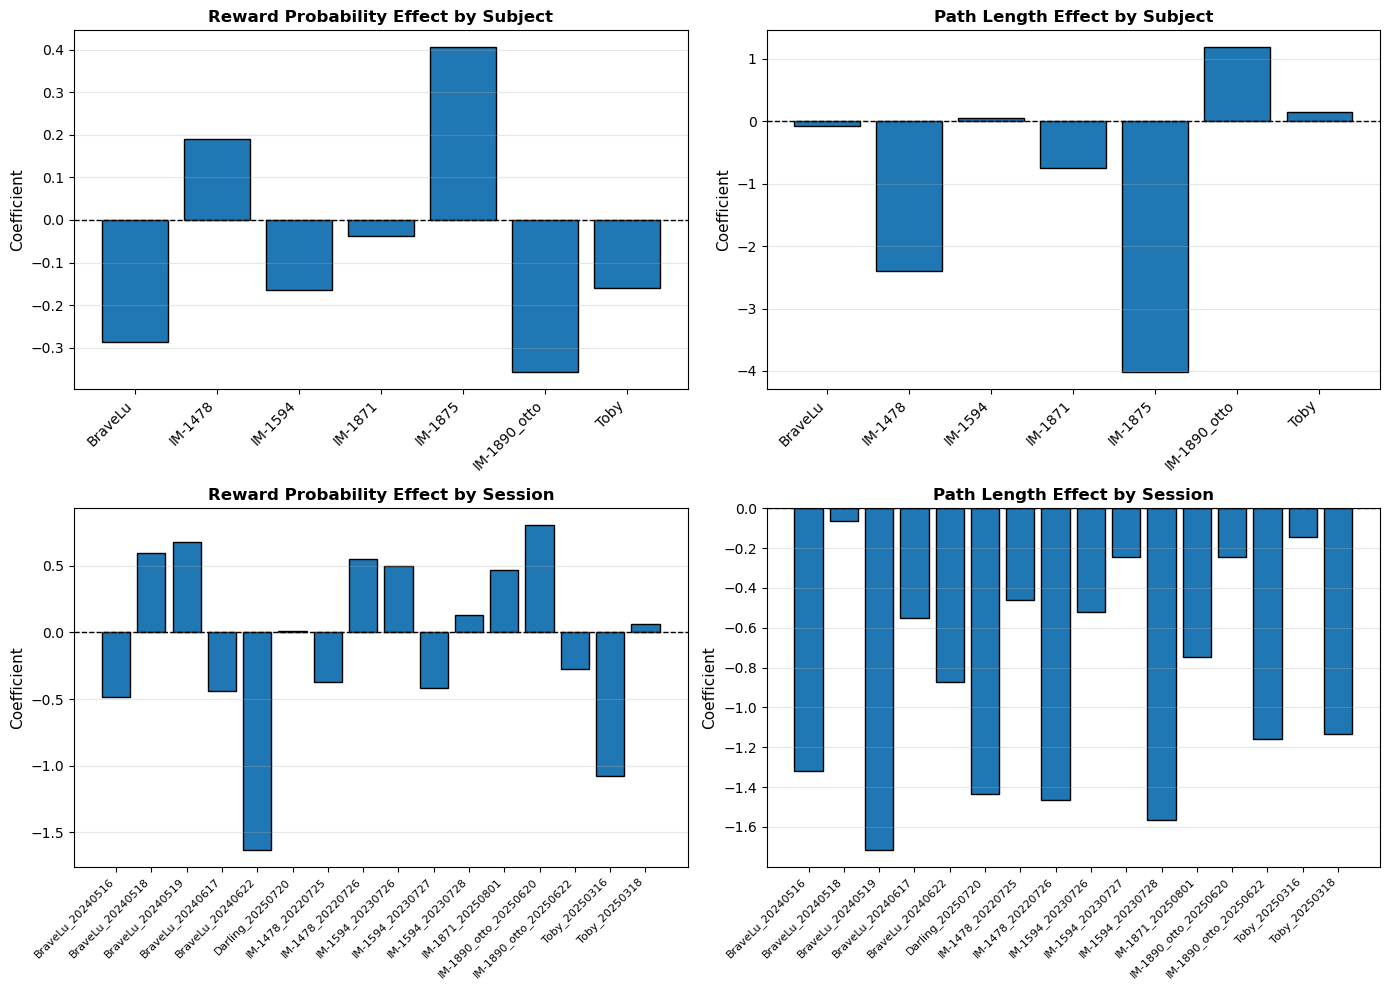

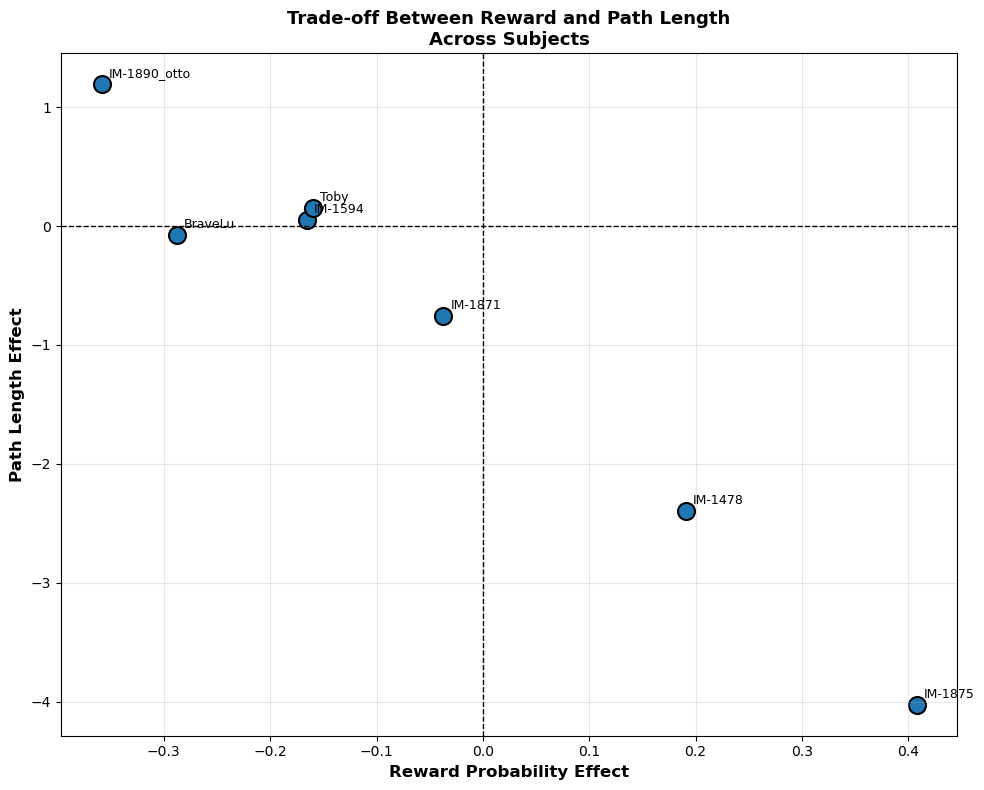

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data
effects_by_subject = pd.read_csv(f"regression_output/effects_by_subject_{name}.csv")
effects_by_session = pd.read_csv(f"regression_output/effects_by_session_{name}.csv")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot reward probability effects by subject
subjects = effects_by_subject['subject_id'].values
reward_effects = effects_by_subject['reward_prob_diff_scaled'].values
x_pos = np.arange(len(subjects))

ax1 = axes[0, 0]
ax1.bar(x_pos, reward_effects, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(subjects, rotation=45, ha="right")
ax1.set_ylabel("Coefficient", fontsize=11)
ax1.set_title("Reward Probability Effect by Subject", fontsize=12, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

# Plot path length effects by subject
path_effects = effects_by_subject['path_length_diff_scaled'].values

ax2 = axes[0, 1]
ax2.bar(x_pos, path_effects, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(subjects, rotation=45, ha="right")
ax2.set_ylabel("Coefficient", fontsize=11)
ax2.set_title("Path Length Effect by Subject", fontsize=12, fontweight="bold")
ax2.grid(axis="y", alpha=0.3)

# Plot reward probability effects by session
sessions = effects_by_session['session_id'].values[:20]  # Show first 20 sessions
reward_effects_session = effects_by_session['reward_prob_diff_scaled'].values[:20]
x_pos_session = np.arange(len(sessions))

ax3 = axes[1, 0]
ax3.bar(x_pos_session, reward_effects_session, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xticks(x_pos_session)
ax3.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax3.set_ylabel('Coefficient', fontsize=11)
ax3.set_title('Reward Probability Effect by Session', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot path length effects by session
ax4 = axes[1, 1]
path_effects_session = effects_by_session['path_length_diff_scaled'].values[:20]

ax4.bar(x_pos_session, path_effects_session, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xticks(x_pos_session)
ax4.set_xticklabels(sessions, rotation=45, ha='right', fontsize=8)
ax4.set_ylabel('Coefficient', fontsize=11)
ax4.set_title('Path Length Effect by Session', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'subject_and_session_effects_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot scatter of reward vs path length effects by subject
fig2, ax = plt.subplots(figsize=(10, 8))

ax.scatter(effects_by_subject['reward_prob_diff_scaled'], 
           effects_by_subject['path_length_diff_scaled'],
           s=150, edgecolors='black', linewidth=1.5)

# Add subject labels
for idx, subject in enumerate(effects_by_subject["subject_id"]):
    ax.annotate(
        subject,
        (
            effects_by_subject["reward_prob_diff_scaled"].iloc[idx],
            effects_by_subject["path_length_diff_scaled"].iloc[idx],
        ),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )

ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Reward Probability Effect', fontsize=12, fontweight='bold')
ax.set_ylabel('Path Length Effect', fontsize=12, fontweight='bold')
ax.set_title('Trade-off Between Reward and Path Length\nAcross Subjects', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'reward_vs_pathlength_tradeoff_{name}.png', dpi=300, bbox_inches='tight')
plt.show()


### Save my python attempt for now

But it looks like pymer4.models maybe isn't really well supported so we'll go ahead in R. Or pick a simpler model

In [ ]:
# Try to do this in python!!
# I keep running into this error when doing model.fit() and it makes me sad:
# NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.frame.DataFrame'>'

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pymer4.models import glmer

# Scale predictors between 0-1 to compare effects in common units
# For now we scale across all sessions (what Tim did). But one could argue for within-session scaling instead
scaler = MinMaxScaler()
regression_df[['reward_prob_diff_scaled', 'path_length_diff_scaled']] = scaler.fit_transform(
    regression_df[['reward_prob_diff', 'path_length_diff']]
)

# Subset trials > 25 to exclude periods when rats are still learning the maze and probabilities of reward
# Could do other filtering here too!
df_subset = regression_df[regression_df['block_trial_num'] > 25]

# Mixed-effects regression (like to Tim's glmer)
model = glmer(
    formula=(
        "choose_left ~ reward_prob_diff_scaled + path_length_diff_scaled "
        "+ (reward_prob_diff_scaled + path_length_diff_scaled | subject_id) "
        "+ (reward_prob_diff_scaled + path_length_diff_scaled | session_id)"
    ),
    data=df_subset,
    family='binomial'
)
results = model.fit()

# Save outputs
results.coefs.to_csv("choose_left_regression_summary.csv")
model.ranef.to_csv("choose_left_regression_coefs_by_rat.csv")